# 1) Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

from utils import load_CIFAR10
from transformers import VisionTransformer

# 2) Loading Data

In [2]:
# config device
device = "cuda" if torch.cuda.is_available() else "cpu"

# load corrupted data and corresponding labels
normal_data_root, corrupt_data_path = "./cifar_data", "CIFAR-10-C.tar", 
corrupt_types = ["gaussian_noise", "motion_blur", "jpeg_compression", "shot_noise", "brightness"]
means, stds = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.247, 0.243, 0.261])
transform = T.Compose([T.ToTensor(), T.Normalize(means, stds)])

normal_data, corrupt_data = load_CIFAR10(normal_data_root, corrupt_data_path,  transform, corrupt_types, device)

Files already downloaded and verified
Files already downloaded and verified


# Visualizing Data

- Visualizing Normal Images from CIFAR-10

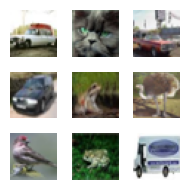

In [3]:
imgs_to_display = [random.randint(0, len(normal_data['train'])-1) for i in range(9)]
fig, axes = plt.subplots(3, 3, figsize=(2, 2))
axes = axes.flatten()
inv_normalize = T.Normalize(
    mean=[-m/s for m, s in zip((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))],
    std=[1/s for s in (0.247, 0.243, 0.261)]
)
for i in range(9):
    img, label = normal_data['train'][imgs_to_display[i]]
    img = inv_normalize(img).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

- Visualizing Corrupted Images from CIFAR-10

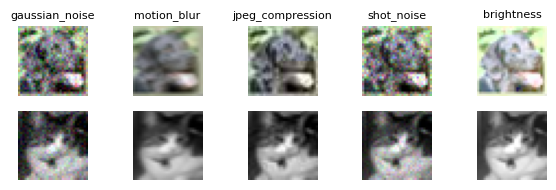

In [4]:
imgs_to_display = [random.randint(0, len(corrupt_data['labels'])-1) for i in range(2)]
fig, axes = plt.subplots(len(imgs_to_display), len(corrupt_data)-1, figsize=(6, 2))

for i in range(len(axes)):
    j = 0
    for key in corrupt_data:
        if key == "labels": continue
        # inverse transformation for plotting
        img = corrupt_data[key][imgs_to_display[i]] * stds.view(3, 1, 1) + means.view(3, 1, 1)
        img = img.permute(1, 2, 0).numpy()
        axes[i][j].imshow(img)
        axes[i][j].axis("off")
        if i == 0:
            axes[i][j].set_title(key, fontsize=8)
        j+=1

plt.tight_layout()
plt.show()

# Model

In [ ]:
# setting seed 
torch.cuda.manual_seed(22)
random.seed(22)
torch.manual_seed(22)

# Hyper-parameters
BATCH_SIZE = 128
PATCH_SIZE = 4
IMG_SIZE = 32
EMBED_DIM = 256
NUM_HEADS = 2
NUM_ENCODERS = 2
NUM_CLASSES = 10
DROPOUT = 0.1

train_loader = DataLoader(dataset=normal_data['train'], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=normal_data['test'], batch_size=BATCH_SIZE, shuffle=False)

model = VisionTransformer(
    EMBED_DIM, IMG_SIZE, PATCH_SIZE, NUM_CLASSES, 
    attention_heads=NUM_HEADS, num_encoders=NUM_ENCODERS, dropout=DROPOUT
    ).to(device)


In [ ]:
def deit_small_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/deit/deit_small_patch16_224-cd65a155.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model

def deit_small_distilled_patch16_224(pretrained=False, **kwargs):
    model = DistilledVisionTransformer(
        patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            url="https://dl.fbaipublicfiles.com/deit/deit_small_distilled_patch16_224-649709d9.pth",
            map_location="cpu", check_hash=True
        )
        model.load_state_dict(checkpoint["model"])
    return model